# Part A Convolution Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation



## Initializing Libaries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import keras_tuner as kt
import visualkeras
from keras.regularizers import l1, l2
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping

Using TensorFlow backend


## Checking GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Fixing random seed

In [306]:
seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

## factors to consider/research

- overfitting (how to prevent it)
    - data augmentation
    - L1 and L2 regulazation
    - dropout layers
    - 
- how does the various parameter of a model (dense layers, parameters of dense layers, activation fucntions, optimizers, learning rate, weigh initilzation, et...)
- affect it eg its accuracy and how does it learn/ will it have vanishing gradient / exploding gradient or any other problems?
- training time and efficiency
    - batch size
- 

## Problem statement
Our problem for this assignment is to create a deep learning model to predict vegatables using the dataset on vegatables.

We need to create 2 seperate final models to predict images on 2 different input sizes:
- 31 x 31
- 128 x128 

## Goals of this project
### Generalise to data well
> To make sure our model is able to generalise to data well, we need to __minimize__ the difference between our training accuracy and test accuracy.
### Accuracy
> In order to minimize avoidable bias, it is important for the model to achieve a training set accuracy of at least __85%__ or higher, which signifies a reasonable level of accuracy.

# Importing Datasets

In [4]:
directory_train = './datasets/Dataset for CA1 part A/train'
directory_test = './datasets/Dataset for CA1 part A/test'
directory_validation = './datasets/Dataset for CA1 part A/validation'

def dataset(directory,image_size,seed=seed,batch_size=64):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        color_mode='grayscale',
        image_size=image_size,
        shuffle=True,
        seed=seed,
        batch_size=batch_size
    )
    return dataset


In [5]:
dataset_train_31 = dataset(directory_train,(31,31))
dataset_test_31 = dataset(directory_test,(31,31))
dataset_validation_31 = dataset(directory_validation,(31,31))

dataset_train_128 = dataset(directory_train,(128,128))
dataset_test_128 = dataset(directory_test,(128,128))
dataset_validation_128 = dataset(directory_validation,(128,128))

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


# EDA
What can we get from our EDA?
- How does the average image look like for each class?
- How is the class distribution?
- How does a sample image look like for each class?


In [6]:
class_labels = [
    "Bean",
    "Bitter Gourd",
    "Bottle Gourd",
    "Brinjal",
    "Broccoli",
    "Cabbage",
    "Capsicum",
    "Carrot",
    "Cauliflower",
    "Cucumber",
    "Papaya",
    "Potato",
    "Pumpkin",
    "Radish",
    "Tomato",
]

In [7]:
for images, labels in dataset_train_31.take(1):
    print("31x31 Batch Shape:", images.shape)
for images, labels in dataset_train_128.take(1):
    print("128x128 Batch Shape:", images.shape)

31x31 Batch Shape: (64, 31, 31, 1)
128x128 Batch Shape: (64, 128, 128, 1)


Our image shapes are 31x31 and 128x128, with a single colour channel.

We have a default batch size of 64, since tf.keras.preprocessing.image_dataset_from_directory requires a default batch size or else the model wont fit properly. Fortunatly we can set our batch size again when we fit our models.

### Visualizing our datasets

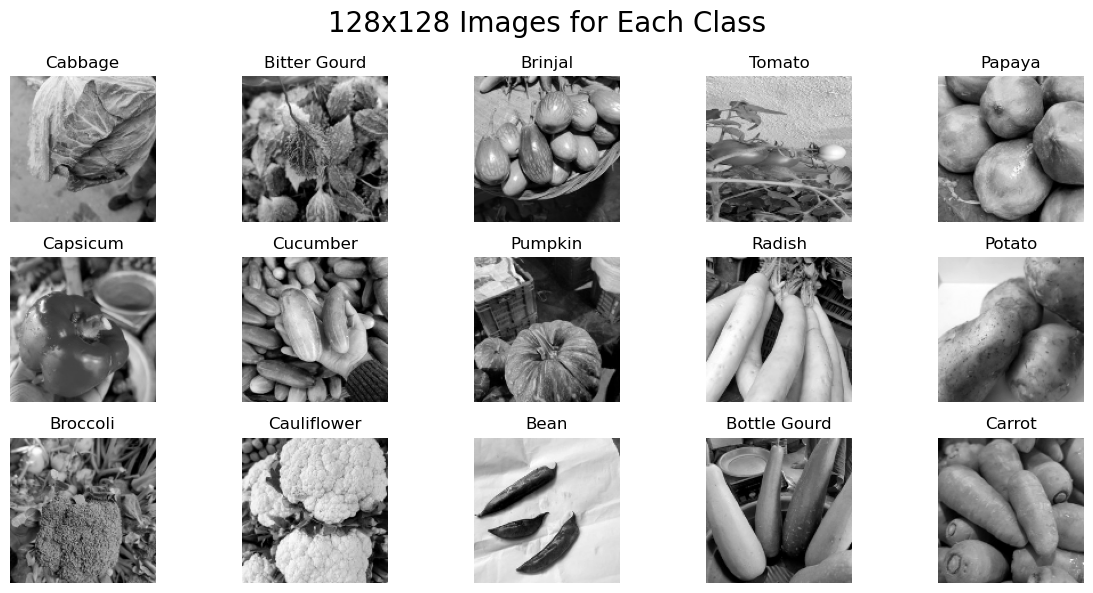

In [8]:
def plot_unique_images(dataset, title, class_labels):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=20)
    unique_images = []  
    unique_labels = []  

    #get unique images
    for images, labels in dataset:
        for i, label in enumerate(labels):
            label_idx = tf.argmax(label).numpy()
            if label_idx not in unique_labels:
                unique_images.append(images[i].numpy().astype("uint8"))
                unique_labels.append(label_idx)

            if len(unique_images) == len(class_labels):
                break 
        if len(unique_images) == len(class_labels):
            break  

    num_images = len(unique_images)
    row = int(np.sqrt(num_images))
    col = int(np.ceil(num_images / row))

    for i in range(num_images):
        ax = plt.subplot(row, col, i + 1)
        plt.imshow(unique_images[i], cmap='gray')
        plt.title(class_labels[unique_labels[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_unique_images(dataset_train_128, '128x128 Images for Each Class', class_labels)

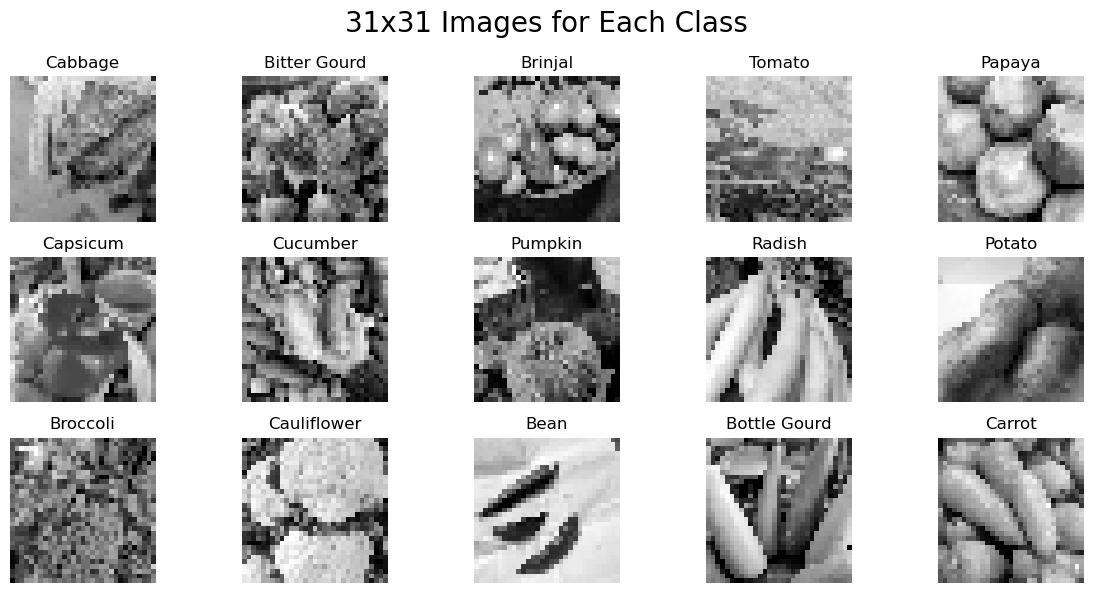

In [9]:
plot_unique_images(dataset_train_31, '31x31 Images for Each Class', class_labels)

Observations:
- We can hardly differentiate some images between classes for images of size 31x31(brocoli,bitter_gourd), hopefully our model can better differeniate these images better than humans!

Now lets get a wider sample range of pictures of every class, to see how diverse the classes are.

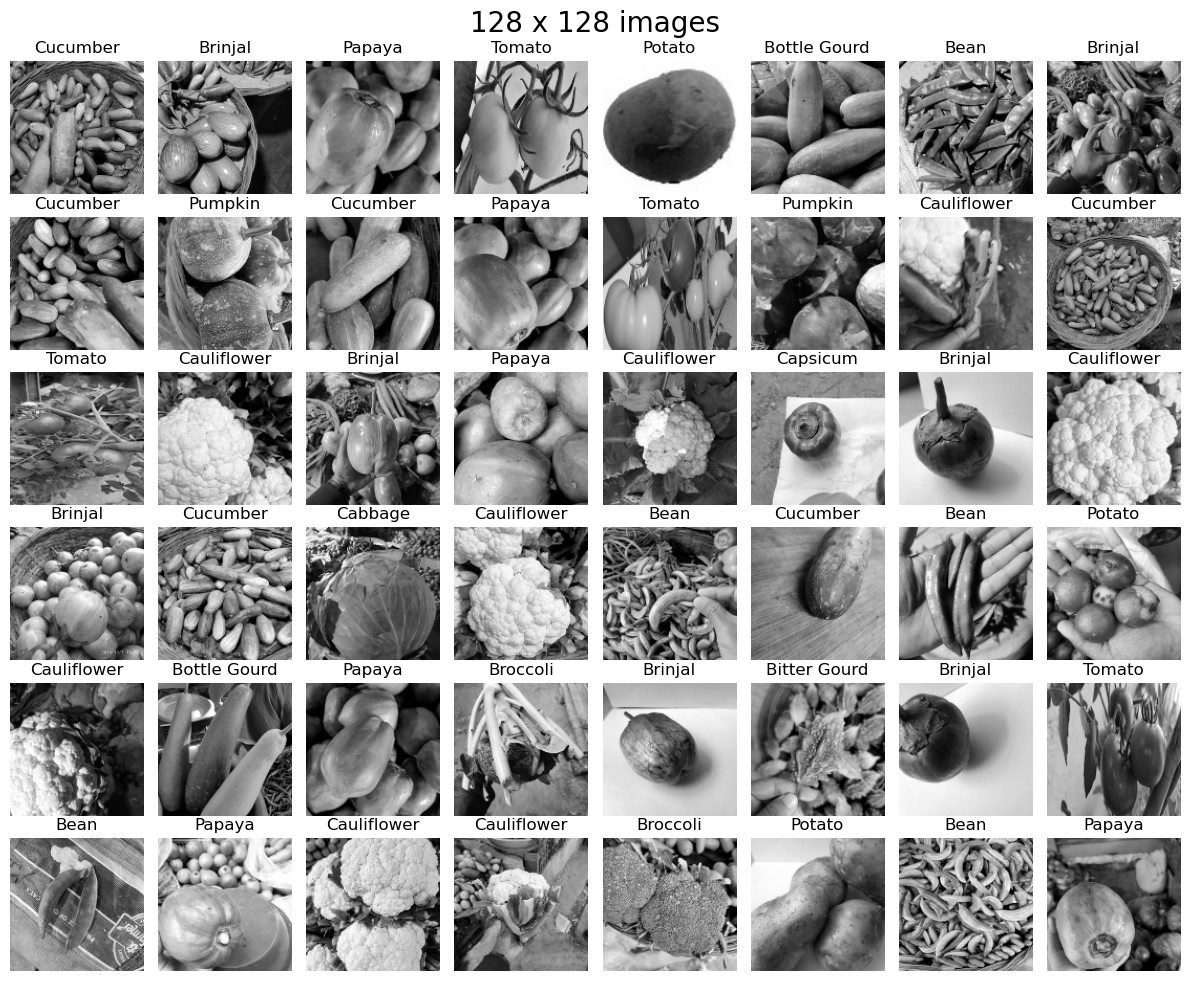

In [10]:
def plot_dataset_huge(amtOfImages, dataset,title,class_labels):
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=20)
    for images, labels in dataset.take(1):
        num_images = len(images)  

        row = int(np.sqrt(amtOfImages))
        col = int(np.ceil(amtOfImages / row))
            
        for i in range(min(amtOfImages, num_images)):
            ax = plt.subplot(row, col, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(class_labels[np.argmax(labels[i])])
            plt.axis("off")

    plt.subplots_adjust(wspace=0.1, hspace=0.01)
    plt.tight_layout()
    plt.show()

plot_dataset_huge(48,dataset_train_128,'128 x 128 images',class_labels)

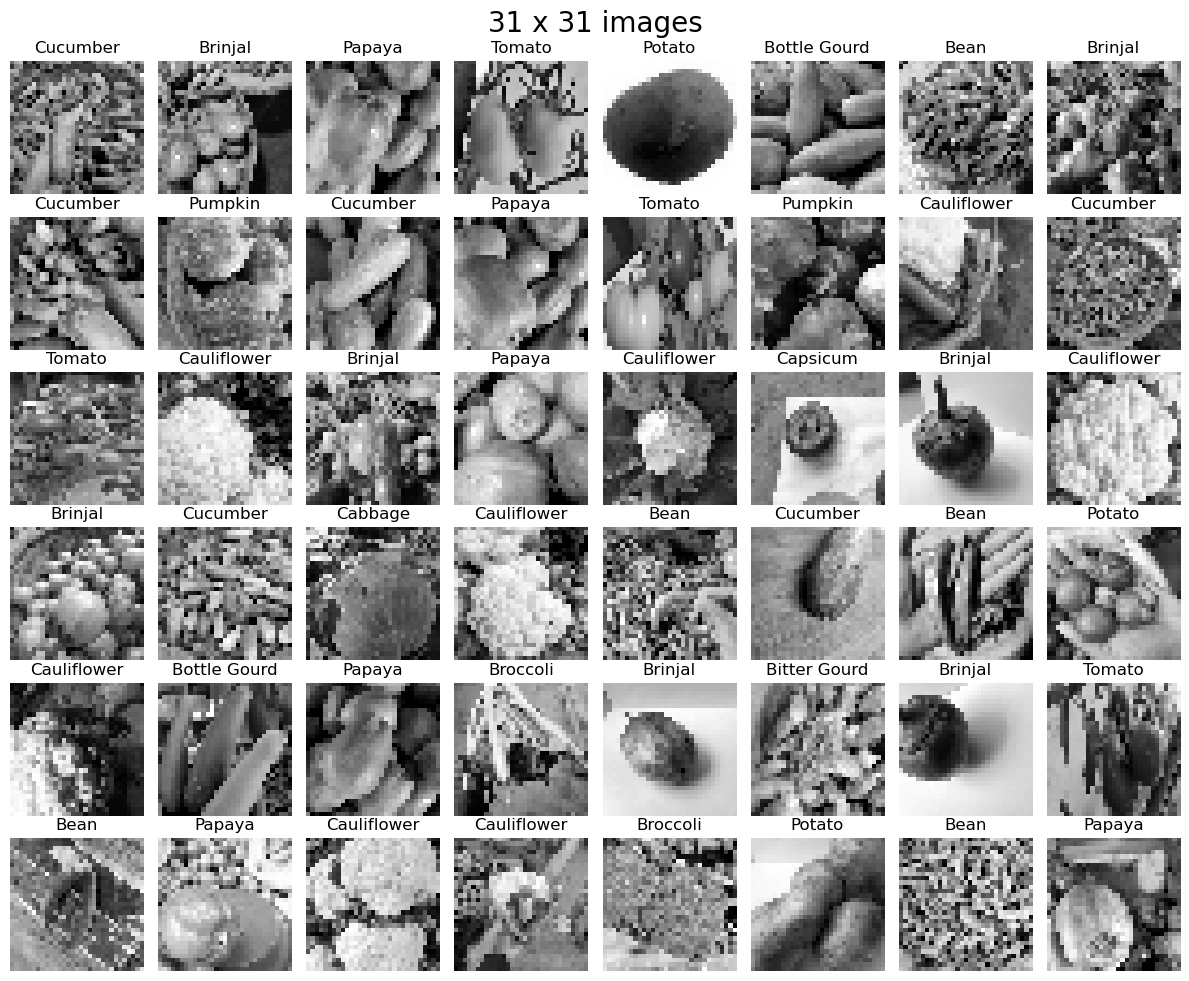

In [11]:
plot_dataset_huge(48,dataset_train_31,'31 x 31 images',class_labels)

Observations:
- Cauliflowers and Potatos are easily differentiable, with potatos usually having a white background and cauliflowers having 

### Class Distribution

In [12]:
class_counts_df = pd.DataFrame(columns=class_labels)

def count_classes(dataset, class_labels):
    class_count = {label: 0 for label in class_labels}
    for _, labels in dataset:
        for label in labels:
            class_name = class_labels[tf.argmax(label)]
            class_count[class_name] += 1
    return class_count

class_counts_df.loc['Validation'] = count_classes(dataset_validation_128, class_labels)
class_counts_df.loc['Training'] = count_classes(dataset_train_128, class_labels)
class_counts_df.loc['Test'] = count_classes(dataset_test_128, class_labels)
class_counts_df.loc['Total Classes'] = class_counts_df.sum()
class_counts_df['Total Datasets'] = class_counts_df.sum(axis=1)

class_counts_df

,Bean,Bitter Gourd,Bottle Gourd,Brinjal,Broccoli,Cabbage,Capsicum,Carrot,Cauliflower,Cucumber,Papaya,Potato,Pumpkin,Radish,Tomato,Total Datasets
Validation,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,3000
Training,780,720,441,868,750,503,351,256,587,812,566,377,814,248,955,9028
Test,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,3000
Total Classes,1180,1120,841,1268,1150,903,751,656,987,1212,966,777,1214,648,1355,15028


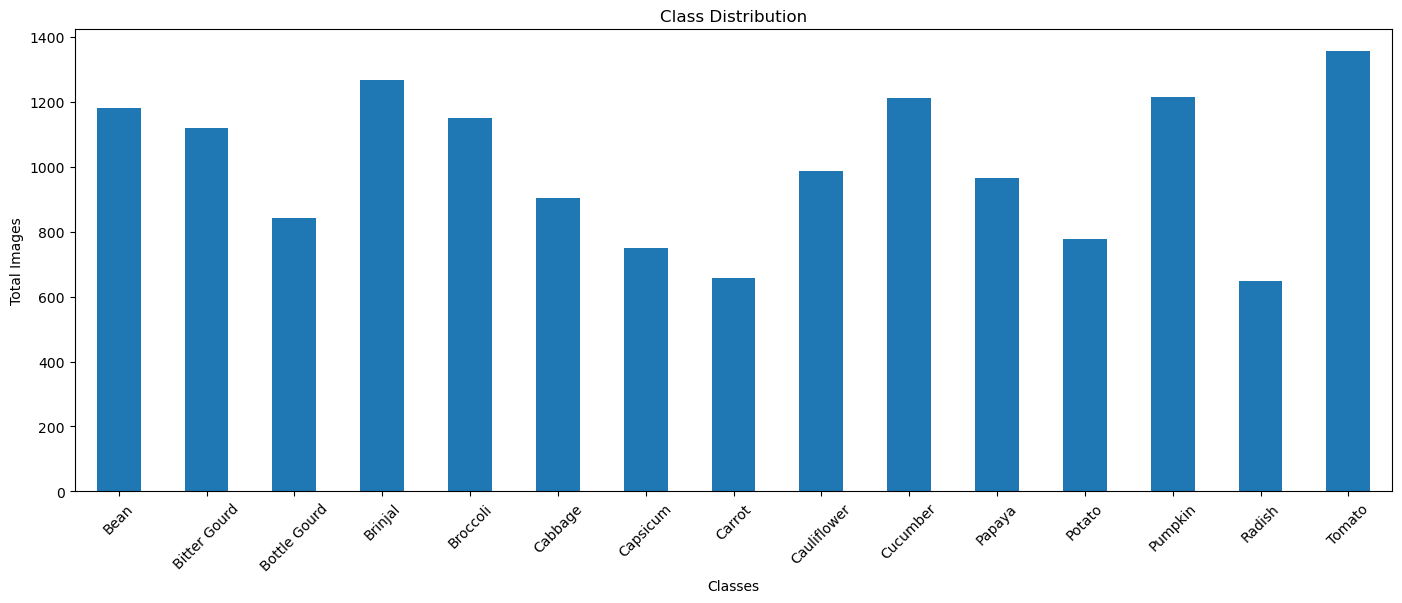

In [13]:
class_counts_df_plot = class_counts_df.drop(['Total Datasets'], axis=1)
class_counts_df_plot = class_counts_df_plot.T
class_counts_df_plot

# Plot the bar graph
class_counts_df_plot['Total Classes'].plot(kind='bar', figsize=(17, 6))
plt.xlabel('Classes')
plt.ylabel('Total Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

We can see that we have an class imbalance for our train dataset. Oh No!! What should we do?
- There are quite alot of solutions for this problem, here are 3 main solutions:
    1. We can __augment our data on the minority classes__(Bottle_gourd, carrots and radish). However we want to also augment our other images classes to prevent overfitting so this is not a good option.
    2. We can __oversample or undersample our minority or majority classes__.However oversampling can lead to overfitting without any data augmentation.
    3. We can __modify the loss function__ to assign different weights to each class, such as increasing the loss weigh for our minority class.


#### Why will we be using differing class weights?
We will be assigning different weights for each class for a few reasons:
- It helps __preserve our existing data__, as in our case we have classes that have a much smaller number of samples (Carrots and Radishs) compared to others.We effectively tell the model to pay more attention to the minority classes. 
- __Prevents overfitting__. As our model is encouraged to strike a balance between minimizing the loss and ensuring that all our classes are predicted accurately. 
- __Simpler than Image oversampling__. Using differing class weights can be more advantagous than image oversampling due to its increased computational costs and potential for overfitting without image augmentation.

In [14]:
class_counts_df_plot['Training'].values

array([780, 720, 441, 868, 750, 503, 351, 256, 587, 812, 566, 377, 814,
       248, 955], dtype=int64)

We will be calculating the class weights using only the train data, as it is the only dataset with imbalanced classes.

In [15]:
class_weights = tf.math.reciprocal(tf.constant(
(class_counts_df_plot['Training'].values).astype(np.float32)))

# Normalize the class weights
class_weights = class_weights / tf.reduce_sum(class_weights)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights.numpy())}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.042979263, 1: 0.046560865, 2: 0.07601774, 3: 0.038621914, 4: 0.04469843, 5: 0.06664775, 6: 0.09550946, 7: 0.13095243, 8: 0.05711043, 9: 0.041285496, 10: 0.05922937, 11: 0.088922605, 12: 0.041184057, 13: 0.1351767, 14: 0.03510348}


#### Another important question to ask is. 
- What are our pixel distributions for our datasets? and what is the std and mean of them? 

In [16]:
def compute_statistics(dataset,title):
    pixel_min = float('inf') 
    pixel_max = float('-inf')
    pixel_sum = 0
    pixel_sum_square = 0
    num_pixels = 0

    for images, _ in dataset:
        for image in images:
            # Calculate min and max pixel values
            pixel_min = min(pixel_min, np.min(image))
            pixel_max = max(pixel_max, np.max(image))

            # Update sum and sum of squares for mean and std calculation
            pixel_sum += np.sum(image)
            pixel_sum_square += np.sum(image ** 2)
            num_pixels += np.prod(image.shape)

    # Calculate mean and std
    pixel_mean = pixel_sum / num_pixels
    pixel_std = np.sqrt((pixel_sum_square / num_pixels) - (pixel_mean ** 2))

    print(title)
    print("Min Pixel Value:", pixel_min)
    print("Max Pixel Value:", pixel_max)
    print("Mean Pixel Value:", pixel_mean)
    print("Standard Deviation:", pixel_std)

    return

compute_statistics(dataset_train_31,'Training Images')
compute_statistics(dataset_test_31,'Test Images')
compute_statistics(dataset_validation_31,'Validation Images')

Training Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 114.34127948859215
Standard Deviation: 55.387912533676406
Test Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 114.66371605098855
Standard Deviation: 55.07995207606749
Validation Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 113.78344607803287
Standard Deviation: 55.49623592897191


- Our pixel values range from 0 to 255, which is expected as grayscale images typically have pixel values ranging from 0 (black) to 255 (white). 
- Our average pixel is around 114, which means that our images are not heavily skewed toward either very dark or very bright values.

### Image Averaging
We will be using only the test and validation datasets for averaging as the train set has class imbalance and may result in inaccurate results.

In [17]:
def calculate_mean_image(datasets, image_size, title):
    pixel_sum = np.zeros((image_size[0], image_size[1]), dtype=np.float64)
    num_images = 0
    mean_images = np.zeros((image_size[0], image_size[1]), dtype=np.float64)

    for dataset in datasets:
        for images, _ in dataset:
            for image in images:
                pixel_sum += np.squeeze(image, axis=-1)
                num_images += 1

    # Calculate the mean image
    mean_image = pixel_sum / num_images
    mean_images = mean_images + mean_image
    
    mean_images = mean_images / len(datasets)

    return mean_images

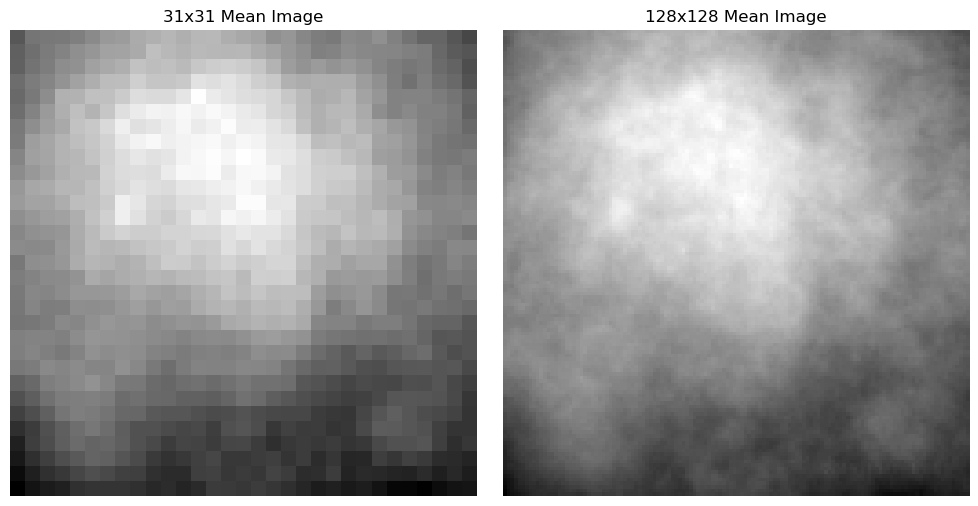

In [18]:
image_size_31 = (31, 31)
image_size_128 = (128, 128)

mean_image_31 = calculate_mean_image([dataset_test_31, dataset_validation_31], image_size_31, 'Average Mean Image (31x31)')
mean_image_128 = calculate_mean_image([dataset_test_128, dataset_validation_128], image_size_128, 'Average Mean Image (128x128)')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mean_image_31, cmap='gray')
plt.title('31x31 Mean Image')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mean_image_128, cmap='gray')
plt.title('128x128 Mean Image')
plt.axis("off")
plt.tight_layout()
plt.show()

The mean image for all the images combined looks like a fog, and we cant really determine any of or classes from this average image.

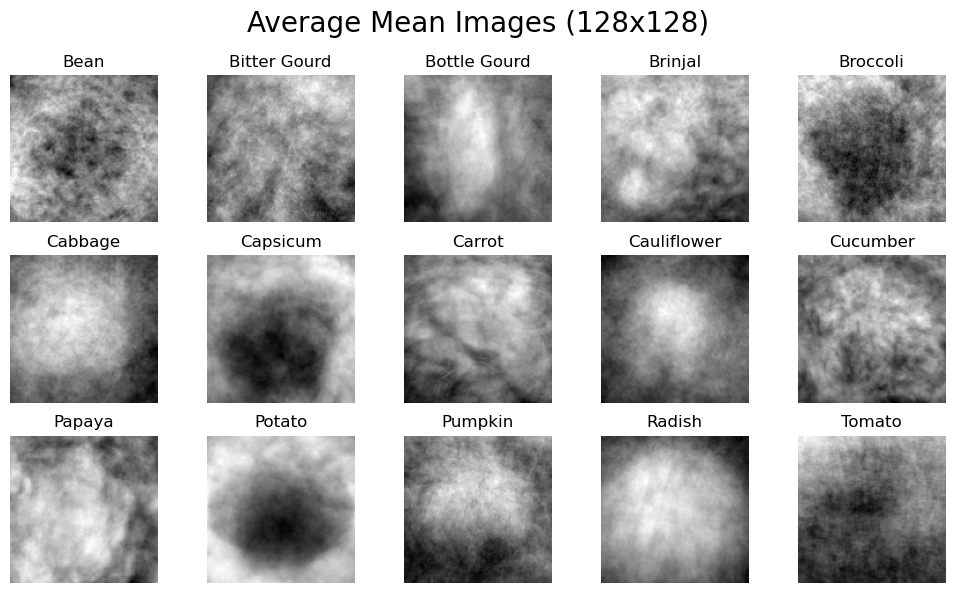

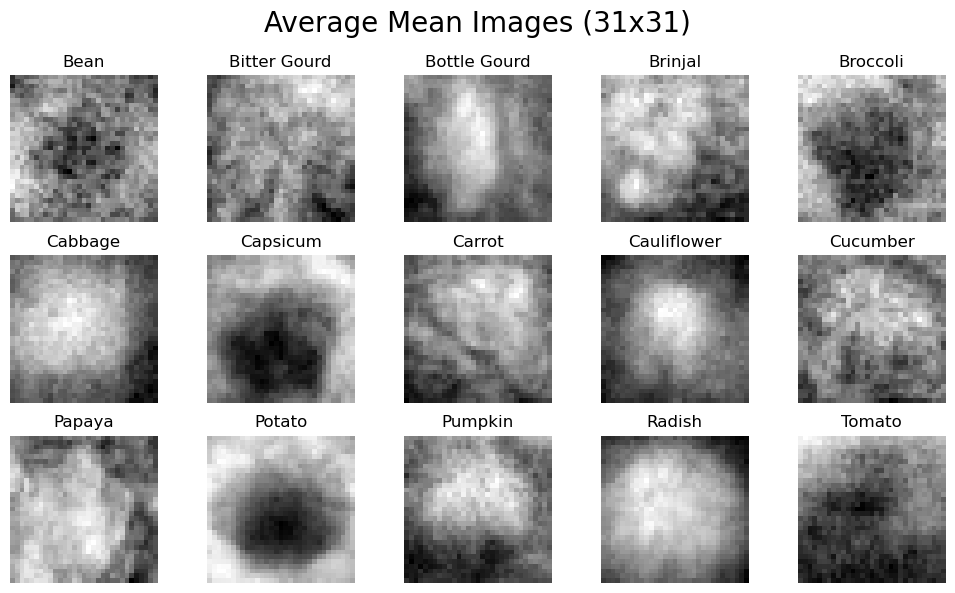

In [19]:
def calculate_class_mean_images(dataset, class_labels, image_size, title,amtOfImages=15):
    class_mean_images = {}  # To store the mean images for each class

    # Initialize mean images for each class
    for class_label in class_labels:
        class_mean_images[class_label] = np.zeros((image_size[0], image_size[1]), dtype=np.float64)

    num_images = 0

    for images, labels in dataset:
        for i, label in enumerate(labels):
            class_label = class_labels[np.argmax(label)]
            class_mean_images[class_label] += np.squeeze(images[i], axis=-1)
            num_images += 1

    num_images = amtOfImages
    row = int(np.sqrt(num_images))
    col = int(np.ceil(num_images / row))

    # Calculate and display the mean image for each class
    plt.figure(figsize=(10, 6))
    plt.suptitle(title, fontsize=20)

    for i, class_label in enumerate(class_labels):
        mean_image = class_mean_images[class_label] / (class_mean_images[class_label].max() + 1e-8)
        plt.subplot(row,col, i + 1)
        plt.imshow(mean_image, cmap='gray')
        plt.title(class_label)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

calculate_class_mean_images(dataset_test_128, class_labels, image_size_128, 'Average Mean Images (128x128)')
calculate_class_mean_images(dataset_test_31, class_labels, image_size_31, 'Average Mean Images (31x31)')

Observations:
- We can see that the pixels for different classes kind of group together to show where the vegetable is. For example, the average image for potato has a cluster of black pixels in the center, roughly outlining a potato.
- However as the images in the dataset are quite complicated, it is quite hard to differentiate out individual classes without labels.

# Data Preprocessing
We need to preprocess our data to help our models to converge faster ,ie lesser time to train. And helps the model to generalise better and prevent it from overfitting.

### Normalizing our images
__Why do we need to normalize our images?__

As normalizing involves scalling the pixel values of our images between 0 and 1 , this results in our images all having a similiar data distribution. Which makes our models benefit from faster convergence during gradient descent and generalising better.

Normalizing the inputs in our context involves calculating the mean and standard deviation of the training dataset and then applying the following formula to each input:
$$
X_{} = \frac{X_{} - μ_{}}{σ_{}}
$$

In [20]:
# use rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_dataset_train_31 = dataset_train_31.map(lambda x, y: (normalization_layer(x), y))

compute_statistics(normalized_dataset_train_31,'Normalised Training Images')

Normalised Training Images
Min Pixel Value: 0.0
Max Pixel Value: 1.0
Mean Pixel Value: 0.448397200505043
Standard Deviation: 0.21720750670021785


We can see that the range of the new normalised pixel values is between 0 - 1 

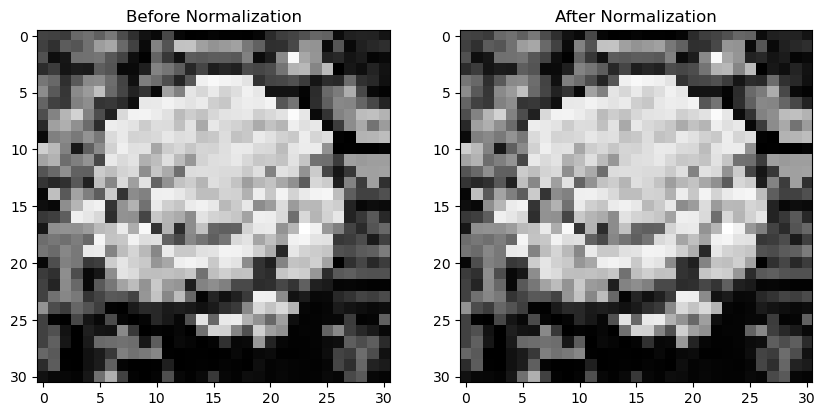

In [21]:
for images, labels in dataset_train_31.take(1):
    original_images = images

normalized_images = normalization_layer(original_images)

original_image = original_images[0]
normalized_image = normalized_images[0]

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(original_image.numpy().squeeze(), cmap='gray')
ax[0].set_title('Before Normalization')

ax[1].imshow(normalized_image.numpy().squeeze(), cmap='gray')
ax[1].set_title('After Normalization')

plt.show()

Observations:
- We can see that normalization dosent significantly affect the visual appearance of our image. Since the original pixel values were already within the same range as before.

### Data Augementation
#### What are image augmentations?
It is a technique that artificially enhances the diversty and variability of our image dataset. It involves applying various transformations to our images such as rotations, flips, scaling, brightness adjustments, and cropping. It is mainly to provide our model with a broader range of training examples which improves its abilty to generalise and predict better on unseen data.
#### Why do we need to augment our images?
There are serveral reasons why we need to augment our images. 
- 1. It increases the amount of images in our train dataset, thus having more "data" for the model to train on. 
- 2. It helps with reducing overfitting,by exposing our model to a wider range of inputs, which promotes robustness and enhances its ability to handle variations.

##### Types of Image Augmentations we will be using:
- flipping (horizontal/ vertically)
- cropping

In [43]:
def augment_images(image,label,size):
    image = tf.map_fn(lambda img: tf.image.random_crop(img, size,seed=seed), image)
    image = tf.image.random_flip_left_right(image,seed=seed)
    image = tf.image.random_flip_up_down(image,seed=seed)
    return image,label

size_31 = [31, 31, 1] 
size_128 = [128, 128, 1]
train_generator_31 = dataset_train_31.map(lambda image, label: augment_images(image, label, size_31))
train_generator_128 = dataset_train_128.map(lambda image, label: augment_images(image, label, size_128))

# Models
### How does a CNN differ from a ANN?
As the name of a CNN suggests, its convolution! As image data is store in arrays, It is deeply inefffcient and unsatisfying to flatten the whole image into an input layer and just feed it through a neural network. With neural network that recognises images having millions of tunable parameters. CNNs help solve that issue, with convolution and pooling layers!
### How does each layer affect our accuracy and efficiency?
We have serveral layers we want to look into here:
#### Convolution Layer(Convo2D)
> - They are basically require in our CNN model to __extract the features__ in our images and can learn hierarchical features.
> - However having too much convolution layers without regularization __can lead to overfitting__  :(
>- Convolutional layers are __computationally intensive__, but their use of shared weights reduces the overall number of parameters compared to fully connected layers, makes them computationally more efficient.  :)
#### Pooling layer
> - Pooling layers downsample feature maps from Convolution layers, reducing its spatial dimensions and computational requirements. :)
>- However excessive pooling may lead to information loss, affecting the model's ability to localize features precisely. :(
> - It increases computational efficiency by reducing the spatial dimensions, which can lead to faster training times and convergence. :)
#### Fully connected layer (Dense)
> - They are the main "brain" of our CNN, they are responsible for combining extracted features for final classification and can capture complex relationships in the data. :)
> - Too many parameters in dense layers can lead to overfitting, especially if our dataset is small which in our case it is. :(
> - Dense layers are alot more computationally expensive due to the large number of parameters, possibly slowing down training times. :( 
#### Dropout layer
> - Dropout layers prevent overfitting by randomly deactivating a fraction of neurons during training, encouraging our CNN to learn more robust features. :)
> - However if the dropout layer is too aggressive, it may prevent the model to learn any meaningful features or patterns, lowering the accuracy. :(
> - 


#### Models choosen
- Base
- custom model resnet
- custom vg16
- need research more

### Choosing Optimization Algorithm
### Overfitting prevention

* compare between augmented/ non-augmented images

params for .fit (steps_per_epoch=None,
    validation_steps=None, verbose,callbacks)

## Utilty Functions

# Hyperparemeter Tuning

# Final Model